# Multilayer Perceptron (MLP) for the names dataset 

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



In [2]:
words = open('data/names.txt', 'r').read().split()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

## Tokenization

In [4]:
chars = sorted(list(set(''.join(words))))
stringToIndex = {char:index + 1 for index, char in enumerate(chars)}
stringToIndex['.'] = 0
indexToString = {index:char for char, index in stringToIndex.items()}
print(indexToString)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Building the dataset
block_size = 3
X, Y = [], []
for word in words:
    # print(word)
    context = [0] * block_size
    for ch in word + '.':
        ix = stringToIndex[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(indexToString[i] for i in context), '------->', indexToString[ix])
        context = context[1:] + [ix] # Crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)
X.shape

torch.Size([228146, 3])

In [6]:
# Embedding layer
C = torch.randn((27, 2))
emb = C[X]

# Weights to the hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn((100,))

## 3 ways to reshape the embedding layer

In [7]:
# Not useful, hard coded. What if my block_size changes?
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1)

tensor([[ 1.0966, -1.4002,  1.0966, -1.4002,  1.0966, -1.4002],
        [ 1.0966, -1.4002,  1.0966, -1.4002,  0.5659, -0.0033],
        [ 1.0966, -1.4002,  0.5659, -0.0033, -0.4381,  1.0622],
        ...,
        [ 0.9959, -0.9085,  0.9959, -0.9085, -1.0437, -0.2549],
        [ 0.9959, -0.9085, -1.0437, -0.2549,  0.9959, -0.9085],
        [-1.0437, -0.2549,  0.9959, -0.9085,  0.4727, -0.0234]])

In [8]:
# Not efficient, we are creating another tensor
torch.cat(torch.unbind(emb, dim = 1), dim = 1)

tensor([[ 1.0966, -1.4002,  1.0966, -1.4002,  1.0966, -1.4002],
        [ 1.0966, -1.4002,  1.0966, -1.4002,  0.5659, -0.0033],
        [ 1.0966, -1.4002,  0.5659, -0.0033, -0.4381,  1.0622],
        ...,
        [ 0.9959, -0.9085,  0.9959, -0.9085, -1.0437, -0.2549],
        [ 0.9959, -0.9085, -1.0437, -0.2549,  0.9959, -0.9085],
        [-1.0437, -0.2549,  0.9959, -0.9085,  0.4727, -0.0234]])

In [9]:
# Efficient way
emb.view(-1, block_size * C.shape[1])

tensor([[ 1.0966, -1.4002,  1.0966, -1.4002,  1.0966, -1.4002],
        [ 1.0966, -1.4002,  1.0966, -1.4002,  0.5659, -0.0033],
        [ 1.0966, -1.4002,  0.5659, -0.0033, -0.4381,  1.0622],
        ...,
        [ 0.9959, -0.9085,  0.9959, -0.9085, -1.0437, -0.2549],
        [ 0.9959, -0.9085, -1.0437, -0.2549,  0.9959, -0.9085],
        [-1.0437, -0.2549,  0.9959, -0.9085,  0.4727, -0.0234]])

In [10]:
h = torch.tanh(emb.view(-1, block_size * C.shape[1])@(W1) + b1)
h.shape

torch.Size([228146, 100])

### Output layer

In [11]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h@W2 + b2
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)
loss = prob[torch.arange(len(Y)), Y].log().neg().mean()

In [15]:
loss

tensor(17.9100)

In [13]:
prob[torch.arange(prob.shape[0]), Y]

tensor([1.3716e-09, 8.8659e-08, 4.6781e-05,  ..., 1.5520e-08, 1.6692e-13,
        5.1354e-05])

In [14]:
prob.shape[0]

228146

# Rewriting everything:

In [41]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2))

# Generating random parameters
W1 = torch.randn((block_size * C.shape[1], 100))
b1 = torch.randn((100,))
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]
print("number of parameters: " + str(sum(p.numel() for p in params)))
# Forward pass:

# Embedding layer
emb = C[X]

# First hidden layer
h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)

# Output layer
logits = h@W2 + b2

# Softmax layer (We can use cross_entropy easily. But we are doing it manually)
counts = logits.exp()
prob = counts/counts.sum(1, keepdim=True)
loss = prob[torch.arange(len(Y)), Y].log().neg().mean()
print(loss.item())
# Use cross_entropy
loss2 = F.cross_entropy(logits, Y) 
print(loss2.item())

if loss.item() == loss2.item():
    print("Both losses are the same")
else:
    print("The algorithm is estimating the loss in a different way")

number of parameters: 3481
16.71360969543457
16.713611602783203
The algorithm is estimating the loss in a different way


In [42]:
for p in params:
    p.requires_grad_()

In [43]:
# Forward pass:
for _ in range(100):
    # Embedding layer
    emb = C[X]

    # First hidden layer
    h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)

    # Output layer
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # Backward pass
    for p in params:
        p.grad = None

    loss.backward()

    for p in params:
        # print(p.grad)
        p.data -= .2 * p.grad

16.713611602783203
13.3214750289917
11.637941360473633
10.510458946228027
9.527788162231445
8.657879829406738
7.923840045928955
7.2516608238220215
6.7268171310424805
6.3022589683532715
5.964947700500488
5.725965976715088
5.502017974853516
5.363192081451416
5.056499481201172
4.9138264656066895
4.706515789031982
4.625739574432373
4.481625080108643
4.449097156524658
4.304779529571533
4.276742935180664
4.161706924438477
4.137618064880371
4.047755718231201
4.0283403396606445
3.9538369178771973
3.9378418922424316
3.8742263317108154
3.86049222946167
3.8054115772247314
3.7930920124053955
3.7446653842926025
3.733241319656372
3.6900429725646973
3.6793389320373535
3.6402695178985596
3.6302614212036133
3.5945167541503906
3.5852088928222656
3.5521793365478516
3.543553352355957
3.5127906799316406
3.504812717437744
3.476043939590454
3.468707323074341
3.4417285919189453
3.435014247894287
3.4096932411193848
3.403580665588379
3.379816770553589
3.3742899894714355
3.3519461154937744
3.3469719886779785
3.3

## Minibatch + Learning rate

In [83]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2))

# Generating random parameters
W1 = torch.randn((block_size * C.shape[1], 100))
b1 = torch.randn((100,))
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]
print("number of parameters: " + str(sum(p.numel() for p in params)))

# Hyperparams: 
learning_rate = .5
n_epochs = 10000
batch_size = 128

for p in params:
    p.requires_grad_()
    
for _ in range(n_epochs):
    # Mini-batch construction:
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    
    # Forward pass:
    # Embedding layer
    emb = C[X[ix]]

    # First hidden layer
    h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)

    # Output layer
    logits = h@W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update
    for p in params:
        # print(p.grad)
        p.data -= learning_rate * p.grad

# Print loss with the whole dataset
# Forward pass:
# Embedding layer
emb = C[X]
h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Y)
print(loss.item())

number of parameters: 3481
2.422227621078491


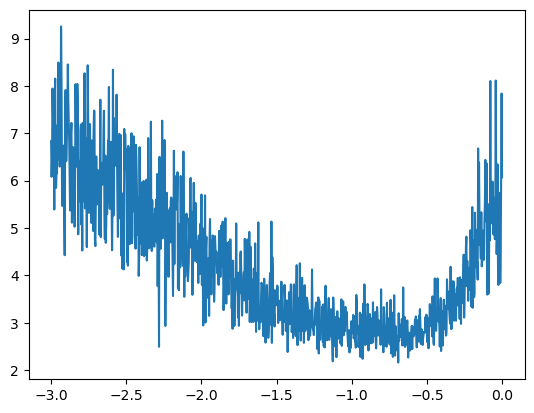

In [73]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

# lri = []
# lossi = []

# for i in range(1000):
#     ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
#     emb = C[X[ix]]
#     h = torch.tanh(emb.view(-1, block_size * C.shape[1])@W1 + b1)
#     logits = h@W2 + b2
#     loss = F.cross_entropy(logits, Y[ix])
        
#     for p in params:
#         p.grad = None
#     loss.backward()
#     lr = lrs[i]
#     for p in params:
#         p.data -= lr * p.grad
    
#     lri.append(lr)
#     lossi.append(loss.item())
    
# plt.plot(lre, lossi)

In [81]:
C

tensor([[ 0.5503, -0.8003],
        [ 0.4155, -0.2591],
        [-0.1665,  0.3929],
        [-0.2675,  0.5002],
        [-0.3795,  0.3426],
        [ 0.2083, -0.0662],
        [-0.3318,  0.5028],
        [-0.1253,  0.5736],
        [-0.3054,  0.0953],
        [ 0.0068, -0.1841],
        [-0.4745, -0.0020],
        [-0.4328,  0.1795],
        [-0.2519,  0.3851],
        [-0.2816,  0.2436],
        [-0.5417, -0.0446],
        [ 0.1134, -0.1754],
        [ 0.1180, -0.2402],
        [-0.0851,  0.3548],
        [-0.2581,  0.1146],
        [-0.1072,  0.3516],
        [-0.2014,  0.3621],
        [ 0.1038, -0.1854],
        [-0.4048,  0.4920],
        [-0.3096,  0.0495],
        [-0.1090,  0.0161],
        [-0.0529, -0.2094],
        [-0.3056,  0.3207]], requires_grad=True)